# Model for Similar Images Search using Pretained ResNet50 Model on Caltech101 Dataset and using k neirest Neighbour Machine Learning Algorithm
http://www.vision.caltech.edu/Image_Datasets/Caltech101/

## Download Caltech101 Dataset
http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [4]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xvf 101_ObjectCategories.tar.gz

!mv 101_ObjectCategories caltech101
!rm -rf caltech101/BACKGROUND_Google

--2019-09-30 11:08:10--  http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131740031 (126M) [application/x-tar]
Saving to: ‘101_ObjectCategories.tar.gz’

101_ObjectCategorie 100%[===================>] 125.64M  12.3MB/s    in 11s     

2019-09-30 11:08:21 (11.5 MB/s) - ‘101_ObjectCategories.tar.gz’ saved [131740031/131740031]

101_ObjectCategories/
101_ObjectCategories/BACKGROUND_Google/
101_ObjectCategories/BACKGROUND_Google/tmp
101_ObjectCategories/BACKGROUND_Google/image_0004.jpg
101_ObjectCategories/BACKGROUND_Google/image_0005.jpg
101_ObjectCategories/BACKGROUND_Google/image_0006.jpg
101_ObjectCategories/BACKGROUND_Google/image_0007.jpg
101_ObjectCategories/BACKGROUND_Google/image_0008.jpg
101_ObjectCategories/BACKGROUND_Google/im

## Download and Install Tensorflow 2.0

In [5]:
# !pip install -U tensorflow-gpu==2.0.0-rc0  # install tensorflow 2.0.0 in colab/kaggle

     |████████████████████████████████| 380.5MB 127kB/s 
     |████████████████████████████████| 4.3MB 27.3MB/s 
     |████████████████████████████████| 501kB 48.4MB/s 


## Import Modules

In [6]:
import tensorflow as tf
print(tf.__version__)

import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook  # to display progress bars for loops
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input

2.0.0-rc0


## Common Function to Load Pretrained Models

In [0]:
# define all the pretrained model details in one function
def pretrained_model_picker(name='vgg16'):
    if (name == 'vgg16'):
        model = VGG16(weights='imagenet', include_top=False,
                      input_shape=(224, 224, 3), pooling='max')
    elif (name == 'vgg19'):
        model = VGG19(weights='imagenet', include_top=False,
                      input_shape=(224, 224, 3), pooling='max')
    elif (name == 'mobilenet'):
        model = MobileNet(weights='imagenet', include_top=False, input_shape=(
            224, 224, 3), pooling='max', depth_multiplier=1, alpha=1)
    elif (name == 'inception'):
        model = InceptionV3(weights='imagenet', include_top=False,
                            input_shape=(224, 224, 3), pooling='max')
    elif (name == 'resnet'):
        model = ResNet50(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))
    elif (name == 'xception'):
        model = Xception(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3), pooling='max')
    else:
        print("Specified model not available")
    return model


## Load ResNet50 Pretrained Model without Top classification Model

In [8]:
model_architecture = 'resnet'

model = pretrained_model_picker(model_architecture)

94773248/94765736 [==============================] - 1s 0us/step


## Function to extract features from Image

In [0]:
def extract_features(img_path, model):
  """
  Function to Extract Features from Image and Normalize them
  
  Arguments:
  img_path: full path of image
  model: pretrained model
  """
  input_shape = (224, 224, 3)
  img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
  img_array = image.img_to_array(img)
  expanded_img_array = np.expand_dims(img_array, axis=0)  # resize image to required dimension supported by ResNet50
#     print(expanded_img_array.shape)
  preprocessed_img = preprocess_input(expanded_img_array)
  features = model.predict(preprocessed_img)  # Extract Features
#     print(features.shape)
  flattened_features = features.flatten()
  normalized_features = flattened_features / norm(flattened_features)  # Normalization
  return normalized_features

Each feature is a floating-point value between 0 and 1

In [12]:
features = extract_features('/content/dog-3277416_640.jpg', model)
print(len(features))

100352


## Get the File List

In [0]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
  """
  Get the file list
  Arguments:
  root_dir: path of root directory
  """
  file_list = []
  counter = 1
  for root, directories, filenames in os.walk(root_dir):
      for filename in filenames:
          if any(ext in filename for ext in extensions):
              file_list.append(os.path.join(root, filename))
              counter += 1
  return file_list

provide the path to your dataset and call the function.

In [0]:
# path to the your datasets
root_dir = '/content/caltech101'
filenames = sorted(get_file_list(root_dir))

## Tip

To get a better sense of time, use the super handy tool - tqdm, which shows a progress meter along with the speed per iteration, as well as the time that has passed and expected finishing time. In python, wrap an iterable with tqdm, for example, tqdm(range(10)). Its Jupyter notebook variant is tqdm_notebook.


In [16]:
feature_list = []

# Index through all filenames in the dataset, extract their features, and append it to the previously defined variable.
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

## Write these features to a pickle file so that we can use them in the future without having to recalculate them.

In [0]:
pickle.dump(feature_list, open('/content/features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('/content/filenames-caltech101.pickle','wb'))

# Similarity Search
Given a photograph, our aim is to find another photo in our dataset similar to the current one

 ## Load the pre-computed features

In [0]:
filenames = pickle.load(open('/content/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('/content/features-caltech101-resnet.pickle', 'rb'))

## Run a nearest neighbor model using the brute force algorithm to find the nearest five neighbors based on Euclidean distance

In [19]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])

print(indices)
indices = indices.flatten()
print(indices.shape)
print(int(distances[0][0]))
print(float(distances[0][4]))
print(distances)

[[  0  12  18   4 366]]
(5,)
0
0.9867721796035767
[[1.13483864e-07 9.47930932e-01 9.51029956e-01 9.58063841e-01
  9.86772180e-01]]


## Display first image

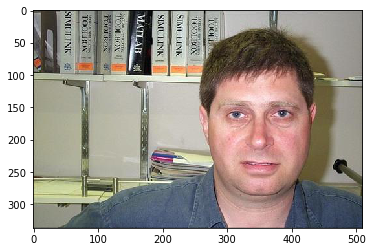

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(filenames[0]))

## Examine the nearest neighbors by plotting the first result.
It will be the same as the origunal image as we are displaying only 1st similar image ans that will be the same image

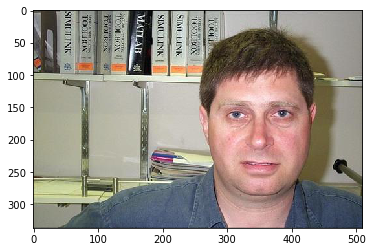

In [21]:
plt.imshow(mpimg.imread(filenames[indices[0]]))

## Functions to get the class name and file name

In [0]:
def classname_filename(str):
  """
  Get Image's class name from complete file path
  Arguments:
  str: Image file path
  """
  return str.split('/')[-2] + '/' + str.split('/')[-1]


def plot_images(filenames, distances):
  """
  Plot 6x4 images with distance in between them
  Arguments:
  filenames: filenames of images
  distances: distances between the similar images
  """
  images = []
  for filename in filenames:
    images.append(mpimg.imread(filename))
    plt.figure(figsize=(15, 10))
    columns = 4
  for i, image in enumerate(images):
    ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
    if i == 0:
      ax.set_title("Query Image\n" + classname_filename(filenames[i]))
    else:
      ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +

    "\nDistance: " + str(float("{0:.2f}".format(distances[i]))))
    plt.imshow(image)

## Visualize the nearest neighbors of six random images. 
Also, note that every time you run the following piece of code, the displayed images will be different because thedisplayed images are indexed by a random integer.

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

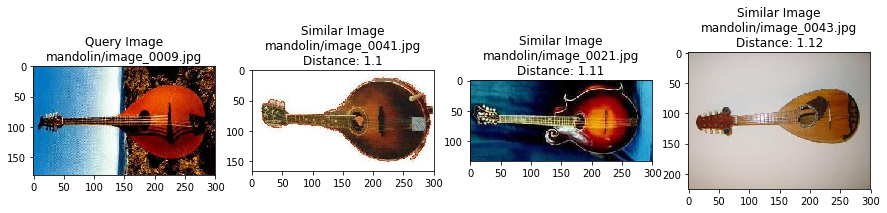

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

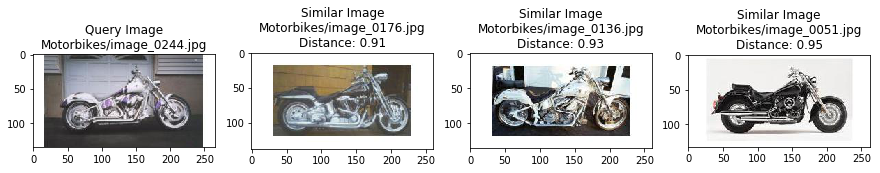

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

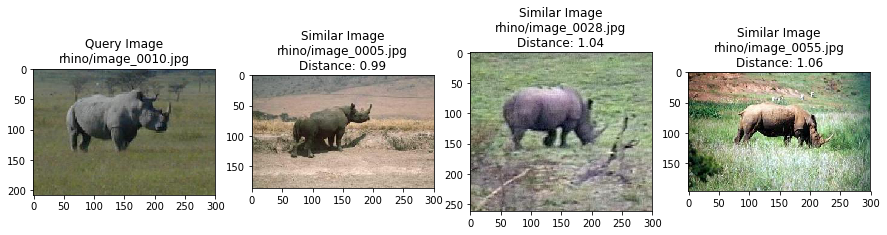

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

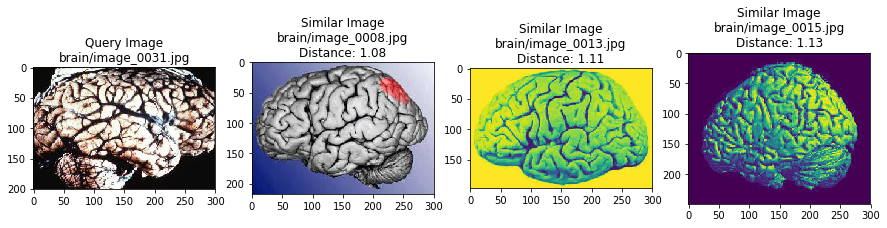

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

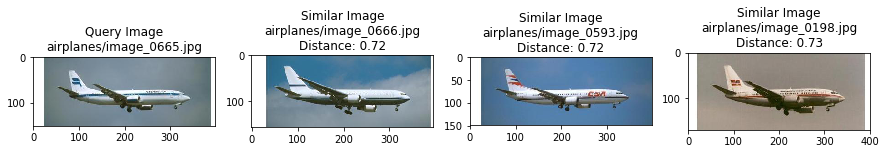

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

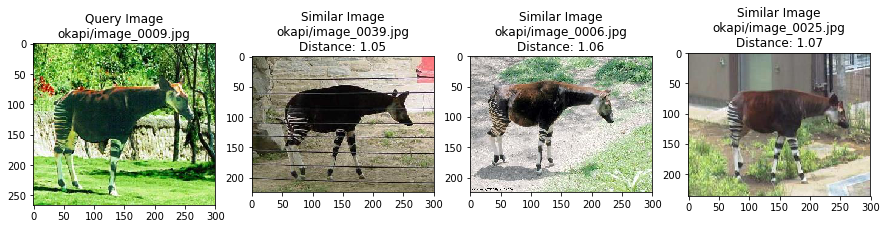

In [24]:
import random
0
for i in range(6):
  random_image_index = random.randint(0,len(filenames))
  distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
  # don’t take the first closest image as it will be the same image
  similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1,4)]
  plot_images(similar_image_paths, distances[0])

In [0]:
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

# #Perform PCA over the features
# numFeatureDimensions=100
# #set the number of features
# pca = PCA(n_components = numFeatureDimensions)
# pca.fit(feature_list)
# featureListCompressed = pca.transform(feature_list)
# #For speed and clarity, we analyze about roughly the first half of the dataset.
# selected_features = featureListCompressed[:4000]
# # selected_class_ids = class_ids[:4000]
# selected_filenames = filenames[:4000]
# tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)
# #Plot a scatter plot from the generated TSNE results
# colormap = plt.cm.get_cmap('coolwarm')
# # scatterPlot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c = selected_class_ids, cmap=colormap)
# scatterPlot = plt.scatter(tsne_results[:,0],tsne_results[:,1], cmap=colormap)
# plt.colorbar(scatterPlot)
# plt.show()

In [0]:
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# from matplotlib.cbook import get_sample_data

# #Helper function to plot images in 2d for t-SNE
# def plot_images_in_2d(x,y, image_paths, axis=None, zoom=1):
#     if axis is None:
#         axis = plt.gca()
#     x, y = np.atleast_1d(x, y)
#     for x0, y0, image_path in zip(x, y, image_paths):
#         image = Image.open(image_path)
#         image.thumbnail((100,100),Image.ANTIALIAS)
#         img = OffsetImage(image, zoom=zoom)
#         anno_box = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
#         axis.add_artist(anno_box)
#     axis.update_datalim(np.column_stack([x, y]))
#     axis.autoscale()

# #Helper function to show the t-SNE plots
# def show_tsne( x,y,selected_filenames):
#     fig, axis = plt.subplots()
#     fig.set_size_inches(22,22, forward=True)
#     plot_images_in_2d(x, y, selected_filenames, zoom=0.3, axis=axis)
#     plt.show()

# show_tsne(tsne_results[:,0],tsne_results[:,1],selected_filenames)